In [2]:
import logging
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import elfi
from sim.utils import ScaledDist, plot_dist
from sim.model import elfi_sim
from sim.sum_stats import elfi_summary
import scipy.stats
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)
elfi.set_client("multiprocessing")

In [ ]:
with open ("../output/priors.pkl", "rb") as f:
    priors = pickle.load(f)

In [43]:
ScaledDist(scipy.stats.lognorm(s=0.7, loc=0, scale=1),
           scipy.stats.lognorm(s=0.7, loc=1, scale=np.exp(3))).target.ppf(1-1e-6)

560.6978117309978

100.62067501562166


[]

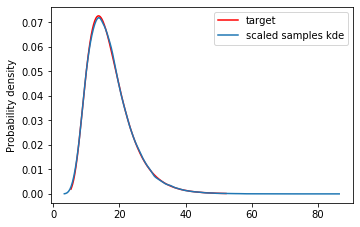

In [54]:
dist = 
print(dist.target.ppf(1-1e-6))
dist.plot()

### Add priors to model and plot

In [ ]:
m = elfi.ElfiModel("m")

elfi.Constant(int(5e6), name="length", model=m)
elfi.Constant(1.8e-8, name="recombination_rate", model=m)
elfi.Constant(6e-8, name="mutation_rate", model=m)

for prior_name, prior in priors.items():
    elfi.Prior(prior.sampling, name=prior_name, model=m)


### POD

In [ ]:
y_obs = elfi_sim(
        bottleneck_strength_domestic=[3000],
        bottleneck_strength_wild=[30000],
        bottleneck_time_domestic=[3000],
        bottleneck_time_wild=[4000],
        captive_time=[20],
        div_time=[35000],
        mig_length_post_split=[1000],
        mig_length_wild=[20],
        mig_rate_captive=[0.01],
        mig_rate_post_split=[0.1],
        mig_rate_wild=[0.01],
        pop_size_captive=[100],
        pop_size_domestic_1=[200],
        pop_size_domestic_2=[200],
        pop_size_wild_1=[200],
        pop_size_wild_2=[200],
        length=int(10e6),
        recombination_rate=1.8e-8,
        mutation_rate=6e-8,
        random_state=np.random.RandomState(3),
        batch_size=1
) 

In [ ]:
prior_args = [m[name] for name in m.parameter_names]  # Model only contains priors and constants

y = elfi.Simulator(elfi_sim, *prior_args, m["length"], m["recombination_rate"],
                   m["mutation_rate"], priors, name="simulator", observed=y_obs)

s = elfi.Summary(elfi_summary, y, None, True, name='s', model=m)

d = elfi.Distance('euclidean', s, name='d', model=m)

### Carry out simulations to "train" sum stat scaler

In [ ]:
seed = 1
pool = elfi.OutputPool(['s'])
rej = elfi.Rejection(m['d'], batch_size=4, seed=1, pool=pool)
rej_res = rej.sample(50, quantile=1, bar=False)  # Accept all
store = pool.get_store('s')
sum_stats = np.array(list(store.values()))
sum_stats = sum_stats.reshape(-1, sum_stats.shape[2])  # Drop batches axis
scaler = StandardScaler()
scaler.fit(sum_stats)
m["s"].become(elfi.Summary(elfi_summary, y, scaler, True, name='s_scaled', model=m))  # Scaler and quick_mode

### SMC

In [ ]:
%%time
logging.getLogger().setLevel(logging.INFO)
smc = elfi.SMC(m['d'], batch_size=5, seed=1)
N = 500
schedule = [12, 11, 10, 9]
result_smc = smc.sample(N, schedule)
result_smc.summary(all=True)

### Collect and write out results

In [ ]:
samples = result_smc.samples_array
weights = result_smc.weights

In [ ]:
results = pd.DataFrame(samples, columns=sorted(priors.keys()))
results["weights"] = result_smc.weights

# scale back up results
for name, dist in scaled_priors.items():
    results[name] = dist.scale_up_samples(results[name])
    
results.to_csv("../output/smc_posterior.csv", index=False)

In [ ]:
# Write out pdfs

df_list = []

for name, dist in priors.items():
    if isinstance(dist, ScaledDist):
        dist = dist.target
    x_lims = dist.ppf([0.001, 0.999])
    x = np.linspace(x_lims[0], x_lims[1], 1000)
    y = dist.pdf(x)
    df = pd.DataFrame({"x": x, "parameter": name, "value": y})
    df_list.append(df)
    
pdf_df = pd.concat(df_list)
pdf_df.to_csv("../output/prior_pdf.csv", index=False)